# Traffis Signs Detection

## 1. Introducción

En el creciente escenario del tráfico vehicular, la identificación y comprensión eficiente de las señales de tráfico son esenciales para garantizar la seguridad en las carreteras y caminos. Sin embargo, el incremento constante en la complejidad de las intersecciones y la diversidad de señales de tráfico presenta un desafío significativo. La interpretación precisa de estas señales no solo es crucial para la seguridad de los conductores, sino también para la implementación efectiva de sistemas de conducción autónoma y tecnologías de asistencia a la conducción.

Se busca abordar esta problemática mediante el desarrollo de modelos de aprendizaje automático que puedan identificar y clasificar de manera precisa las señales de tráfico en entornos variados.
<br><br>

**Problematica**

La incorrecta interpretación de señales de tráfico puede conducir a situaciones, aumentando el riesgo de accidentes y poniendo en peligro la vida de conductores y peatones. La necesidad de un software preciso para la detección de señales de tráfico es evidente, especialmente en el contexto de la evolución hacia vehículos autónomos.
<br><br>

**Como la tecnología puede ayudar**

La aplicación de algoritmos avanzados de procesamiento de imágenes y modelos de aprendizaje automático, como redes neuronales convolucionales, pueden transformar la forma en que las señales de tráfico se detectan y comprenden en entornos dinámicos. Estos modelos pueden aprender patrones complejos y adaptarse a diversas condiciones de iluminación y escenarios de carreteras.

La tecnología no solo puede impactar en la precisión de la detección, sino que también puede el hecho de que pueda hacerlo en tiempo real agrega gran valor, ya que permitiría respuestas rápidas a cambios en el entorno del conductor. Este enfoque tecnológico ademas del reducir potencialmente accidentes, también acerca a la conducción a un entorno más eficiente y seguro.

## 2. Datos

### 2.1 Importación de librerias y descarga de paquetes

In [28]:
!pip install -q kaggle
!pip install opencv-python

In [29]:
# Librerías para operaciones de sistema y manipulación de archivos
import os
import sys
# Módulo para redireccionar la salida estándar a objetos de cadena (StringIO)
from io import StringIO
# Librería para manipulación y análisis de datos tabulares
import pandas as pd
# Librería fundamental para operaciones numéricas
import numpy as np
# Librería para la creación de gráficos y visualización de datos
import matplotlib.pyplot as plt
# Librería para el procesamiento de imágenes
import cv2
# Librería de aprendizaje profundo desarrollada por TensorFlow
import tensorflow as tf
# Módulo de keras, interfaz de alto nivel para TensorFlow
from tensorflow import keras
# Módulos específicos de keras para construir modelos de red neuronal
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# Módulos de keras para regularización
from tensorflow.keras import regularizers
# Módulos de keras para optimizadores y capas
from tensorflow.keras import optimizers, layers, models
# Librería para generar números aleatorios
import random
# Librería para mostrar imágenes en el entorno de la libreta Jupyter
from IPython.display import Image, display
# Módulo de la librería de imágenes Python Imaging Library (PIL)
from PIL import Image as PILImage
# Librería para métricas de evaluación en aprendizaje automático
from sklearn.metrics import accuracy_score
# Capa de activación Leaky ReLU para modelos de keras
from tensorflow.keras.layers import LeakyReLU

In [30]:
# Librería para acceder a las credenciales de kaggle
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/My Drive/kaggle.json' ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
# Librería para descargar el dataset empleado
import kaggle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2.2 Importación del dataset
> El dataset esta conformado por un conjunto de 58 carpetas las cuales representan las diferentes clases; cada clase tiene 120 imagenes, dandonos un total de imagenes de 6,960. <br> Por otro lado, para los datos de testeo se tienen aproximadamente 2000 imagenes.

In [31]:
dataset_name = "ahemateja19bec1025/traffic-sign-dataset-classification"  #Direccion de kaggle
destination_directory = "/content/traffic_sign_dataset"  # Directorio de destino

# Descarga del conjunto de datos
kaggle.api.dataset_download_files(dataset_name, path=destination_directory, unzip=True)

2023-11-11 02:18:53,211 WARNING Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /api/v1/datasets/download/ahemateja19bec1025/traffic-sign-dataset-classification?datasetVersionNumber=None


## 3. Modelo base

### 3.1 Construcción del modelo base

#### 3.1.1 Preprocesamiento de imagenes
> El preprocesamiento simple que se realizo ajusta las imagenes al mismo tamaño, normaliza los valores de los píxeles y los almacena en matrices para su posterior uso en la construcción y entrenamiento de modelos de aprendizaje automático.

In [41]:
# Ruta de los datos
data_dir = '/content/traffic_sign_dataset/traffic_Data/DATA'
# Ruta de las etiquetas
labels_path = '/content/traffic_sign_dataset/labels.csv'

# Cargar etiquetas desde el archivo CSV
labels = pd.read_csv(labels_path)

# Inicializar listas para almacenar datos
data = []
target = []

# Leer las imágenes y etiquetas
for label, label_name in labels.values:
    label_dir = os.path.join(data_dir, str(label))
    for img_file in os.listdir(label_dir):
        img_path = os.path.join(label_dir, img_file)
        image = cv2.imread(img_path) # Lectura de la imagen
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Reorganización de los canales de color
        image = cv2.resize(image, (64, 64))  # Ajuste de tamaño de las imagenes
        data.append(image)
        target.append(label)

# Convertir listas a matrices NumPy
data = np.array(data)
target = np.array(target)

# Normalizar las imágenes
data = data / 255.0


#### 3.1.2 Construcción y entrenamiento del modelo
> El modelo recibe como datos de entrada imagenes de tamaño 64 x 64 con 3 canales de color, tiene 8 capas y trabaja con un total de 471,226 parametros a lo largo de 10 epocas. <br>El modelo utiliza las capas convucionales para extraer las caracteristicas mas importantes de las imagenes para posteriormente realizar la clasificación en las capas densas.<br>
El modelo utiliza el optimizador de Adam, y como función de perdida sparse_categorical_crossentropy la cual es ideal para problemas de clasificación mayores a dos clases, por ultimo tiene como metrica la precisión del modelo.  

In [42]:
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(58, activation='softmax')  # 58 clases de señales de tráfico
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(data, target, epochs=10)

Epoch 1/10
131/131 [==============================] - 28s 202ms/step - loss: 2.0746 - accuracy: 0.5062
Epoch 2/10
131/131 [==============================] - 30s 230ms/step - loss: 0.5041 - accuracy: 0.8683
Epoch 3/10
131/131 [==============================] - 27s 205ms/step - loss: 0.1926 - accuracy: 0.9504
Epoch 4/10
131/131 [==============================] - 33s 253ms/step - loss: 0.0620 - accuracy: 0.9861
Epoch 5/10
131/131 [==============================] - 29s 218ms/step - loss: 0.0140 - accuracy: 0.9971
Epoch 6/10
131/131 [==============================] - 32s 243ms/step - loss: 0.0176 - accuracy: 0.9954
Epoch 7/10
131/131 [==============================] - 30s 227ms/step - loss: 0.0657 - accuracy: 0.9830
Epoch 8/10
131/131 [==============================] - 27s 207ms/step - loss: 0.0176 - accuracy: 0.9962
Epoch 9/10
131/131 [==============================] - 30s 228ms/step - loss: 0.0147 - accuracy: 0.9966
Epoch 10/10
131/131 [==============================] - 27s 206ms/step - l

### 3.2 Evaluación del modelo base

#### 3.2.1 Precisión del modelo base con los datos de testeo
>  Se realiza la carga y procesamiento de las imagenes de prueba, el cual es igual a procesamiento de las imagenes de entrenameinto, para calcular la precisión del modelo mediante la comparación de las etiquetas predichas con las reales. <br> <br> En este caso se presenta un caso de overfitting ya que la precisión en los datos de entrenamiento es muy buena y para los datos de prueba mala, lo que indica que el modelo se esta ajustando de más a los patrones que ve en el entrenamiento

In [43]:
# Ruta al directorio de pruebas
test_data_dir = '/content/traffic_sign_dataset/traffic_Data/TEST'

# Cargar y preprocesar las imágenes de prueba (ajusta según tu modelo)
X_test = []  # Almacena las imágenes de prueba
y_test_true = []  # Almacena las etiquetas verdaderas de prueba

for image_file in os.listdir(test_data_dir):
    image_path = os.path.join(test_data_dir, image_file)
    image = PILImage.open(image_path)
    image = image.resize((64, 64))  # Ajusta el tamaño de la imagen
    image = np.array(image) / 255.0  # Normaliza la imagen
    X_test.append(image)

    # Extrae la etiqueta del nombre del archivo
    label = int(image_file.split("_")[0])
    y_test_true.append(label)

X_test = np.array(X_test)
y_test_true = np.array(y_test_true)

# Realizar predicciones en el conjunto de prueba
y_test_pred = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred, axis=1)

# Calcular la precisión
accuracy = accuracy_score(y_test_true, y_test_pred)

print("Precisión en el conjunto de prueba:", accuracy)

63/63 [==============================] - 5s 73ms/step
Precisión en el conjunto de prueba: 0.5687061183550652


#### 3.2.2 Predicciones del modelo base utilizando imagenes


> Se realizan algunas predicciones utilizando imagenes aleatorias, al realizar distintas pruebas pude notar que las imagenes utilizadas para prueba no presentan la mejor calidad, algunas teniendo demasiado ruido, estando bastante alejadas o muestras sus colores muy opacos, lo que dificulta su distinción.



1/1 [==============================] - 0s 26ms/step


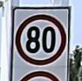

Clase real: 7 , speed limit (80km/h)
Clase predicha: 2 , Speed limit (30km/h)


In [51]:
# Obtener una lista de archivos de imagen en el directorio de pruebas
image_files = os.listdir(test_data_dir)

# Elegir una imagen aleatoria
random_image_file = random.choice(image_files)

# Ruta completa de la imagen aleatoria
random_image_path = os.path.join(test_data_dir, random_image_file)

# Preprocesamiento de la imagen
image = PILImage.open(random_image_path)
image = image.resize((64, 64))  # Ajusta el tamaño según el modelo
image = np.array(image)
image = image / 255.0  # Normaliza la imagen

# Enviar la imagen al modelo
predictions = model.predict(np.expand_dims(image, axis=0))

# Obtener la clase predicha
predicted_class = np.argmax(predictions)

#Obtener las etiquetas
nombre_de_clase = labels.loc[labels['ClassId'] == int(random_image_path[49:51]), 'Name'].values[0]
nombre_de_prediccion= labels.loc[labels['ClassId'] == int(predicted_class), 'Name'].values[0]

# Mostrar la imagen
display(Image(filename=random_image_path))
print("Clase real:", int(random_image_path[49:51]), ",", nombre_de_clase)
print("Clase predicha:", predicted_class,",",nombre_de_prediccion)

## 4. Convolutional Nerual Network (Modified)

### 4.1 Preprocesamiento de datos de entrenamiento

#### 4.1.1 Preprocesamiento con intensificacion de colores (Rojo, Azul, Negro)
> Este preprocesamiento consiste en la intensificación de los colores clave para las señales de trafico, esto busca facilitar la tarea de clasificación de imagenes nuevas al modelo al mejorar las imegenes.

In [52]:
# Definir la ruta de los datos
data_dir = '/content/traffic_sign_dataset/traffic_Data/DATA'
labels_path = '/content/traffic_sign_dataset/labels.csv'

# Cargar etiquetas desde el archivo CSV
labels = pd.read_csv(labels_path)

# Inicializar listas para almacenar datos
data = []
target = []

# Valores de escalamiento de colores
blue_intensity = 1.5  # Intensificación del color azul
black_intensity = 1.8  # Intensificación del color negro
red_intensity = 1.5  # Intensificación del color rojo

for label, label_name in labels.values:
    label_dir = os.path.join(data_dir, str(label))
    for img_file in os.listdir(label_dir):
        img_path = os.path.join(label_dir, img_file)
        img = cv2.imread(img_path)
        # Normaliza la intensidad de los canales de color
        img[:, :, 0] = np.clip(blue_intensity * img[:, :, 0], 0, 255)
        img[:, :, 1] = np.clip(black_intensity * img[:, :, 1], 0, 255)
        img[:, :, 2] = np.clip(red_intensity * img[:, :, 2], 0, 255)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (64, 64))  # Reajuste del tamaño de las imagenes
        data.append(img)
        target.append(label)

# Convertir listas a matrices NumPy
data = np.array(data)
target = np.array(target)

# Normalizar las imágenes
data = data / 255.0


### 4.2 Construcción y entrenamiento de modelos variando su función de activación
> Para contrarestar el overfitting primeramente se redujo la complejidad del modelo e insertar parametros de regularización (L2), sin embargo los cambios no generaron resultados significativos por lo que no se incorporo en el documento. <br> La tecnica que si mostro mejores resultados fue la de dropout, ya que apaga aleatoriamente neuronas durante el proceso de entrenamiento lo que ayuda a reducir el overfitting. De igual forma el ajustar el learning rate a uno mas bajo ayudo a contrarestar el problema del modelo inicial, aunque provoco que se tuvieran que incrementar las epocas. <br> Adicional a ello se construyeron distintas funciones de activación para probar su efectividad y posteriormente seleccionar la mejor.

#### 4.2.1 Modelo ReLU

In [53]:
relu = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.30),  # Agregar Dropout
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.30),  # Agregar Dropout
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.6),  # Agregar Dropout
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.6),  # Agregar Dropout
    layers.Dense(58, activation='softmax')
])

new_learning_rate = 0.001

# Configura el optimizador con la nueva tasa de aprendizaje
opt = optimizers.Adam(learning_rate=new_learning_rate)

relu.compile(optimizer= opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
relu.fit(data, target, epochs=27)

Epoch 1/27
131/131 [==============================] - 38s 282ms/step - loss: 3.3910 - accuracy: 0.1705
Epoch 2/27
131/131 [==============================] - 33s 255ms/step - loss: 2.2467 - accuracy: 0.4060
Epoch 3/27
131/131 [==============================] - 30s 226ms/step - loss: 1.5296 - accuracy: 0.5736
Epoch 4/27
131/131 [==============================] - 31s 239ms/step - loss: 1.1430 - accuracy: 0.6722
Epoch 5/27
131/131 [==============================] - 33s 250ms/step - loss: 0.9111 - accuracy: 0.7369
Epoch 6/27
131/131 [==============================] - 35s 264ms/step - loss: 0.7475 - accuracy: 0.7808
Epoch 7/27
131/131 [==============================] - 29s 219ms/step - loss: 0.6479 - accuracy: 0.8024
Epoch 8/27
131/131 [==============================] - 34s 262ms/step - loss: 0.5690 - accuracy: 0.8237
Epoch 9/27
131/131 [==============================] - 33s 249ms/step - loss: 0.4795 - accuracy: 0.8477
Epoch 10/27
131/131 [==============================] - 30s 229ms/step - l

#### 4.2.2 Modelo Leaky

In [54]:
leaky = Sequential([
    layers.Conv2D(32, (3, 3), input_shape=(64, 64, 3)),
    LeakyReLU(alpha=0.01),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.30),
    layers.Conv2D(64, (3, 3)),
    LeakyReLU(alpha=0.01),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.30),
    layers.Conv2D(64, (3, 3)),
    LeakyReLU(alpha=0.01),
    layers.Flatten(),
    layers.Dropout(0.6),
    layers.Dense(128),
    LeakyReLU(alpha=0.01),
    layers.Dropout(0.6),
    layers.Dense(58, activation='softmax')
])
new_learning_rate = 0.001

# Configura el optimizador con la nueva tasa de aprendizaje
opt = optimizers.Adam(learning_rate=new_learning_rate)

leaky.compile(optimizer= opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
leaky.fit(data, target, epochs=20)

Epoch 1/20
131/131 [==============================] - 35s 263ms/step - loss: 3.1407 - accuracy: 0.2283
Epoch 2/20
131/131 [==============================] - 34s 258ms/step - loss: 1.7912 - accuracy: 0.5165
Epoch 3/20
131/131 [==============================] - 32s 248ms/step - loss: 1.1490 - accuracy: 0.6736
Epoch 4/20
131/131 [==============================] - 32s 244ms/step - loss: 0.7924 - accuracy: 0.7679
Epoch 5/20
131/131 [==============================] - 39s 297ms/step - loss: 0.5899 - accuracy: 0.8245
Epoch 6/20
131/131 [==============================] - 41s 312ms/step - loss: 0.4599 - accuracy: 0.8583
Epoch 7/20
131/131 [==============================] - 37s 285ms/step - loss: 0.3678 - accuracy: 0.8904
Epoch 8/20
131/131 [==============================] - 37s 283ms/step - loss: 0.3042 - accuracy: 0.9082
Epoch 9/20
131/131 [==============================] - 37s 283ms/step - loss: 0.2726 - accuracy: 0.9158
Epoch 10/20
131/131 [==============================] - 34s 261ms/step - l

#### 4.2.1 Modelo Elu

In [55]:
elu = Sequential([
    layers.Conv2D(32, (3, 3), activation='elu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.30),
    layers.Conv2D(64, (3, 3), activation='elu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.30),
    layers.Conv2D(64, (3, 3), activation='elu'),
    layers.Flatten(),
    layers.Dropout(0.6),
    layers.Dense(128, activation='elu'),
    layers.Dropout(0.6),
    layers.Dense(58, activation='softmax')
])
new_learning_rate = 0.001

# Configura el optimizador con la nueva tasa de aprendizaje
opt = optimizers.Adam(learning_rate=new_learning_rate)
elu.compile(optimizer= opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
elu.fit(data, target, epochs=20)

Epoch 1/20
131/131 [==============================] - 37s 271ms/step - loss: 2.2696 - accuracy: 0.4448
Epoch 2/20
131/131 [==============================] - 38s 293ms/step - loss: 0.7869 - accuracy: 0.7847
Epoch 3/20
131/131 [==============================] - 39s 299ms/step - loss: 0.4473 - accuracy: 0.8712
Epoch 4/20
131/131 [==============================] - 35s 264ms/step - loss: 0.2896 - accuracy: 0.9137
Epoch 5/20
131/131 [==============================] - 35s 269ms/step - loss: 0.2291 - accuracy: 0.9319
Epoch 6/20
131/131 [==============================] - 35s 270ms/step - loss: 0.1889 - accuracy: 0.9460
Epoch 7/20
131/131 [==============================] - 35s 270ms/step - loss: 0.1475 - accuracy: 0.9544
Epoch 8/20
131/131 [==============================] - 39s 296ms/step - loss: 0.1174 - accuracy: 0.9638
Epoch 9/20
131/131 [==============================] - 39s 297ms/step - loss: 0.1330 - accuracy: 0.9573
Epoch 10/20
131/131 [==============================] - 35s 270ms/step - l

#### 4.2.1 Modelo Tanh

In [56]:
tanh = Sequential([
    layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.30),
    layers.Conv2D(64, (3, 3), activation='tanh'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.30),
    layers.Conv2D(64, (3, 3), activation='tanh'),
    layers.Flatten(),
    layers.Dropout(0.6),
    layers.Dense(128, activation='tanh'),
    layers.Dropout(0.6),
    layers.Dense(58, activation='softmax')
])
new_learning_rate = 0.001

# Configura el optimizador con la nueva tasa de aprendizaje
opt = optimizers.Adam(learning_rate=new_learning_rate)
tanh.compile(optimizer= opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tanh.fit(data, target, epochs=15)

Epoch 1/15
131/131 [==============================] - 35s 258ms/step - loss: 2.1336 - accuracy: 0.4851
Epoch 2/15
131/131 [==============================] - 32s 247ms/step - loss: 0.7479 - accuracy: 0.8141
Epoch 3/15
131/131 [==============================] - 33s 249ms/step - loss: 0.4380 - accuracy: 0.8954
Epoch 4/15
131/131 [==============================] - 34s 260ms/step - loss: 0.3208 - accuracy: 0.9209
Epoch 5/15
131/131 [==============================] - 34s 260ms/step - loss: 0.2294 - accuracy: 0.9456
Epoch 6/15
131/131 [==============================] - 39s 300ms/step - loss: 0.1840 - accuracy: 0.9549
Epoch 7/15
131/131 [==============================] - 36s 272ms/step - loss: 0.1465 - accuracy: 0.9664
Epoch 8/15
131/131 [==============================] - 34s 261ms/step - loss: 0.1257 - accuracy: 0.9727
Epoch 9/15
131/131 [==============================] - 33s 248ms/step - loss: 0.1085 - accuracy: 0.9758
Epoch 10/15
131/131 [==============================] - 33s 249ms/step - l

### 4.3 Modificación de preprocesamientos para los datos de prueba
> Adicionalmente a las mejoras empleadas dentro del modelo, se realizaron mejoras en el procesamiento de los datos de prueba, con el objetivo de mejorar dichos datos e incrementar los resultados de precisión del modelo.

#### 4.3.1 Intensificación de colores (Rojo, Negro, Azul)
> Intensifica los colores clave para las señales de trafico, resaltando caracteristicas importantes segun una escala que se definio anteriormente

In [57]:
# Ruta al directorio que contiene las imágenes
images_dir = '/content/traffic_sign_dataset/traffic_Data/TEST'
output_dir = '/content/traffic_sign_dataset/traffic_Data/TEST_processed'

# Crear el directorio de salida si no existe
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Iterar sobre las imágenes y aplicar intensificación de colores
for image_file in os.listdir(images_dir):
    # Ruta completa de la imagen
    image_path = os.path.join(images_dir, image_file)

    # Lee la imagen
    img = cv2.imread(image_path)

    # Normaliza la intensidad de los canales de color
    img[:, :, 0] = np.clip(blue_intensity * img[:, :, 0], 0, 255)
    img[:, :, 1] = np.clip(black_intensity * img[:, :, 1], 0, 255)
    img[:, :, 2] = np.clip(red_intensity * img[:, :, 2], 0, 255)

    # Guarda la imagen procesada
    output_path = os.path.join(output_dir, image_file)
    cv2.imwrite(output_path, img)


#### 4.3.2 Suavizado y relleno de pixeles
> Se aplico un suavizado gaussiano para eliminar parte del ruido de las imagenes, posterior a ello se rellenan los pixeles de las imagenes para mejorar su calidad

In [58]:
# Ruta donde se guardarán las imágenes modificadas
output_dir = '/content/traffic_sign_dataset/traffic_Data/TEST_Gauss'

# Crea la carpeta si no existe
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Itera sobre todas las imágenes en la carpeta de prueba
for img_file in os.listdir(images_dir):
    img_path = os.path.join(images_dir, img_file)

    # Lee la imagen
    img = cv2.imread(img_path)

    #Aplica un filtro gaussiano para suavizar la imagen
    blurred_img = cv2.GaussianBlur(img, (5, 5), 0)

    # Valor de relleno de pixeles
    new_size = (1024, 1024)
    resized_img = cv2.resize(blurred_img, new_size, interpolation=cv2.INTER_CUBIC)
    # Guarda la imagen modificada en la nueva ruta
    ruta_guardado_img = os.path.join(output_dir, img_file)
    cv2.imwrite(ruta_guardado_img, resized_img)

print("Proceso completado. Imágenes modificadas guardadas en:", output_dir)

Proceso completado. Imágenes modificadas guardadas en: /content/traffic_sign_dataset/traffic_Data/TEST_Gauss


#### 4.3.3 Suavizado e intensificación de colores (Rojo, Negro, Azul)
> Se aplican las tecnicas de suavizado posterior la de instensificación de colores

In [59]:
# Ruta donde se guardarán las imágenes modificadas
output_dir = '/content/traffic_sign_dataset/traffic_Data/TEST_GaussColor'

# Crea la carpeta si no existe
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Itera sobre todas las imágenes en la carpeta de prueba
for img_file in os.listdir(images_dir):
    img_path = os.path.join(images_dir, img_file)

    # Lee la imagen
    img = cv2.imread(img_path)

    #Aplica un filtro gaussiano para suavizar la imagen
    blurred_img = cv2.GaussianBlur(img, (5, 5), 0)

    # Ajusta el tamaño a un valor más grande para rellenar pixeles
    new_size = (1024, 1024)
    resized_img = cv2.resize(blurred_img, new_size, interpolation=cv2.INTER_CUBIC)

    # Normaliza la intensidad de los canales de color
    resized_img[:, :, 0] = np.clip(blue_intensity * resized_img[:, :, 0], 0, 255)
    resized_img[:, :, 1] = np.clip(black_intensity * resized_img[:, :, 1], 0, 255)
    resized_img[:, :, 2] = np.clip(red_intensity * resized_img[:, :, 2], 0, 255)

    # Guarda la imagen modificada en la nueva ruta
    ruta_guardado_img = os.path.join(output_dir, img_file)
    cv2.imwrite(ruta_guardado_img, resized_img)

print("Proceso completado. Imágenes modificadas guardadas en:", output_dir)

Proceso completado. Imágenes modificadas guardadas en: /content/traffic_sign_dataset/traffic_Data/TEST_GaussColor


#### 4.3.4 Intensificación de brillo
> Se aplica intensificación del brillo de las imagenes para mejorar aquellas que se muestran opacas, sin alterar las que no, bajo un escalamiento de 1.5

In [60]:
# Ruta donde se guardarán las imágenes modificadas
output_dir = '/content/traffic_sign_dataset/traffic_Data/TEST_Bright'

# Crea la carpeta si no existe
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Itera sobre todas las imágenes en la carpeta de prueba
for img_file in os.listdir(images_dir):
    img_path = os.path.join(images_dir, img_file)

    # Lee la imagen
    img = cv2.imread(img_path)

    # Aumenta el brillo de la imagen
    brightness_factor = 1.5
    brightened_img = cv2.convertScaleAbs(img, alpha=brightness_factor, beta=0)

    # Guarda la imagen modificada en la nueva ruta
    ruta_guardado_img = os.path.join(output_dir, img_file)
    cv2.imwrite(ruta_guardado_img, brightened_img)

print("Proceso completado. Imágenes modificadas guardadas en:", output_dir)

Proceso completado. Imágenes modificadas guardadas en: /content/traffic_sign_dataset/traffic_Data/TEST_Bright


#### 4.3.5 Intensificación de brillo y relleno de pixeles
> Se aplica la tecnica de intensificación de brillo y posterior se rellenan los pixeles

In [61]:
# Ruta donde se guardarán las imágenes modificadas
output_dir = '/content/traffic_sign_dataset/traffic_Data/TEST_ResizeBright'

# Crea la carpeta si no existe
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Itera sobre todas las imágenes en la carpeta de prueba
for img_file in os.listdir(images_dir):
    img_path = os.path.join(images_dir, img_file)

    # Lee la imagen
    img = cv2.imread(img_path)

    # Aplica un filtro gaussiano para suavizar la imagen
    blurred_img = img

    # Ajusta el tamaño a un valor más grande para rellenar pixeles
    new_size = (1024, 1024)
    resized_img = cv2.resize(blurred_img, new_size, interpolation=cv2.INTER_CUBIC)

    # Aumenta el brillo de la imagen
    brightness_factor = 1.5
    brightened_img = cv2.convertScaleAbs(resized_img, alpha=brightness_factor, beta=0)

    # Guarda la imagen modificada en la nueva ruta
    ruta_guardado_img = os.path.join(output_dir, img_file)
    cv2.imwrite(ruta_guardado_img, brightened_img)

print("Proceso completado. Imágenes modificadas guardadas en:", output_dir)

Proceso completado. Imágenes modificadas guardadas en: /content/traffic_sign_dataset/traffic_Data/TEST_ResizeBright


## 5. Evaluación de desempeño con datos de prueba
> Se itera sobre todos los modelos construidos anteriormente y sobre los distintos preprocesamientos, para compararlos segun su precisión y determinar cual es el mejor modelo

In [62]:
# Ruta al directorio de pruebas
processed_test = {
    "Original" : '/content/traffic_sign_dataset/traffic_Data/TEST',
    "Colors" : '/content/traffic_sign_dataset/traffic_Data/TEST_processed',
    "Resize_Gauss" : '/content/traffic_sign_dataset/traffic_Data/TEST_Gauss',
    "Gauss_Colors": '/content/traffic_sign_dataset/traffic_Data/TEST_GaussColor',
    "Bright" : '/content/traffic_sign_dataset/traffic_Data/TEST_Bright',
    "Resize_Bright": '/content/traffic_sign_dataset/traffic_Data/TEST_ResizeBright'

}

models_list = {
    "Relu" : relu,
    "LeakyRelU" : leaky,
    "Elu" : elu,
    "Tanh" : tanh
}

for modelo in models_list.keys() :
  print(f"\nModelo: {modelo}\n")
  model = models_list[modelo]
  for directory in processed_test.keys():
    test_data_dir = processed_test[directory]
    # Cargar y preprocesar las imágenes de prueba (ajusta según tu modelo)
    X_test = []  # Almacena las imágenes de prueba
    y_test_true = []  # Almacena las etiquetas verdaderas de prueba

    for image_file in os.listdir(test_data_dir):
        image_path = os.path.join(test_data_dir, image_file)
        image = PILImage.open(image_path)
        image = image.resize((64, 64))  # Ajusta el tamaño según tu modelo
        image = np.array(image) / 255.0  # Normaliza la imagen
        X_test.append(image)

        # Extraer la etiqueta del nombre del archivo (suponiendo que el nombre del archivo contiene la etiqueta)
        label = int(image_file.split("_")[0])
        y_test_true.append(label)

    X_test = np.array(X_test)
    y_test_true = np.array(y_test_true)

    # Realizar predicciones en el conjunto de prueba
    y_test_pred = model.predict(X_test)
    y_test_pred = np.argmax(y_test_pred, axis=1)

    # Calcular la precisión
    accuracy = accuracy_score(y_test_true, y_test_pred)

    print(f"Preprocesamiento: {directory} Precisión en el conjunto de prueba:", accuracy)


Modelo: Relu

63/63 [==============================] - 3s 54ms/step
Preprocesamiento: Original Precisión en el conjunto de prueba: 0.7091273821464393
63/63 [==============================] - 6s 94ms/step
Preprocesamiento: Colors Precisión en el conjunto de prueba: 0.7372116349047142
63/63 [==============================] - 4s 57ms/step
Preprocesamiento: Resize_Gauss Precisión en el conjunto de prueba: 0.6970912738214644
63/63 [==============================] - 4s 58ms/step
Preprocesamiento: Gauss_Colors Precisión en el conjunto de prueba: 0.7362086258776329
63/63 [==============================] - 5s 73ms/step
Preprocesamiento: Bright Precisión en el conjunto de prueba: 0.7231695085255767
63/63 [==============================] - 6s 89ms/step
Preprocesamiento: Resize_Bright Precisión en el conjunto de prueba: 0.7221664994984955

Modelo: LeakyRelU

63/63 [==============================] - 5s 71ms/step
Preprocesamiento: Original Precisión en el conjunto de prueba: 0.720160481444333
63/63

## 6. Selección del modelo

> Finalmente según los resultados obtenidos anteriormente se selecciona el mejor modelo y el mejor procesamiento para las imagenes de prueba, en este caso el mejor modelo fue aquel que utilizo la función de activación de LeakyReLU junto con el procesamiento de aumento de colores y suavizado en las imagenes.<br> Según los resultados del modelo se observa una gran mejoría con respecto al modelo base, con un incremento de la precisión en .1735 puntos.

### 6.1 Predicciones del modelo seleccionado
> Por ultimo se muestran las predicciones del modelo seleccionado con imagenes aleatorias


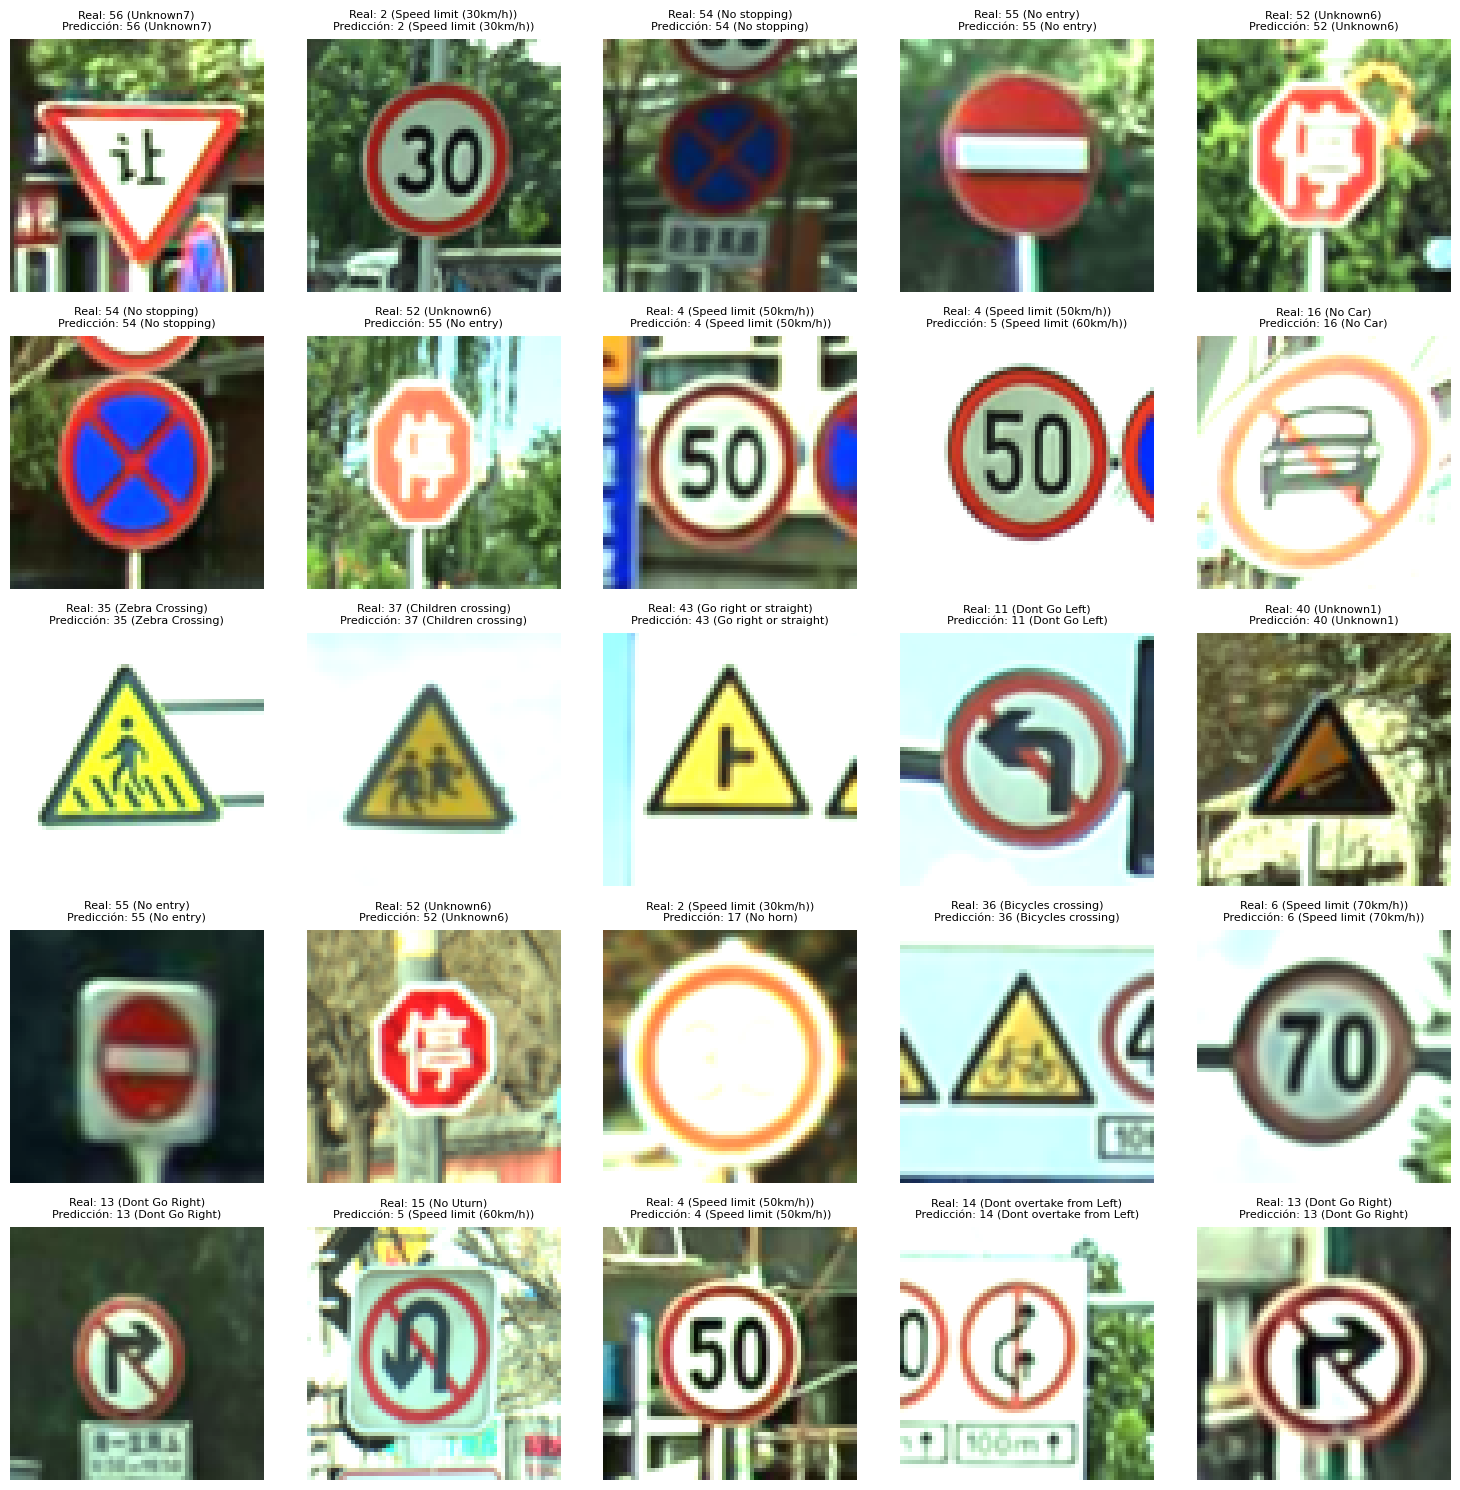

Porcentaje de predicciones correctas: 84.00%


In [64]:
# Definir el número de filas y columnas en el cuadro
num_rows = 5
num_cols = 5

# Crear una figura con un cuadro de 5x5 subgráficos
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Modelo seleccionado
model = leaky

# Obtener una lista de archivos de imagen en el directorio de pruebas
test_data_dir = '/content/traffic_sign_dataset/traffic_Data/TEST_GaussColor'
image_files = os.listdir(test_data_dir)

# Inicializar el contador de predicciones correctas
correct_predictions = 0

# Salida original
original_stdout = sys.stdout

# Redirige la salida estándar a un objeto StringIO vacío (esto evita la impresión)
sys.stdout = StringIO()

# Iterar sobre las filas y columnas del cuadro
for i in range(num_rows):
    for j in range(num_cols):
        # Elegir una imagen aleatoria
        random_image_file = random.choice(image_files)
        random_image_path = os.path.join(test_data_dir, random_image_file)

        # Preprocesamiento de la imagen
        image = PILImage.open(random_image_path)
        image = image.resize((64, 64))
        image = np.array(image)
        image = image / 255.0

        # Enviar la imagen al modelo
        predictions = model.predict(np.expand_dims(image, axis=0))

        # Obtener la clase predicha
        predicted_class = np.argmax(predictions)

        # Obtener las etiquetas
        real_class = int(random_image_file.split("_")[0])
        real_class_name = labels.loc[labels['ClassId'] == real_class, 'Name'].values[0]
        predicted_class_name = labels.loc[labels['ClassId'] == int(predicted_class), 'Name'].values[0]

        # Verificar si la predicción es correcta
        is_correct = real_class == predicted_class

        # Contar las predicciones correctas
        correct_predictions += 1 if is_correct else 0

        # Mostrar la imagen en el subgráfico correspondiente
        axs[i, j].imshow(image)
        axs[i, j].axis('off')
        axs[i, j].set_title(
            f"Real: {real_class} ({real_class_name})\nPredicción: {predicted_class} ({predicted_class_name})",
            fontsize=8
        )
sys.stdout = original_stdout
# Ajustar el diseño para evitar solapamientos
plt.tight_layout()
plt.show()

# Imprimir el porcentaje de predicciones correctas
accuracy_percentage = (correct_predictions / (num_rows * num_cols)) * 100
print(f"Porcentaje de predicciones correctas: {accuracy_percentage:.2f}%")


## 7. Conclusiones
> Los resultados obtenidos por el modelo son buenos, teniendo una precisión del 74% en los datos de conjunto de prueba, un 17% más en comparación del modelo base, lo que indica la mejoría del modelo, sin embargo, bajo el contexto de la problematica la precisión del modelo determinara la confianza que tengan los usuarios en el producto, siguiendo la proporción de cuanto mayor sea la precisión mayor uso del modelo, aunado a esto tambien significara que tan bueno o malo es el modelo para evitar accidentes y ayudar al conductor al manejar su vehiculo. <br> <br> La clave para aumentar la precisión radica en el preprocesamiento de imágenes. Un enfoque futuro podría centrarse en estrategias más avanzadas para mejorar la calidad de las imágenes, como una mejor eliminación de ruido y optimización de la calidad de las imagenes. Estas mejoras no solo tendrían un impacto directo en la precisión del modelo, sino que también fortalecerían su capacidad para adaptarse a diversas condiciones de iluminación y entornos de las vías, para llevar a cabo estas mejoras se requieren mejores equipos de computo, los cuales puedan procesar diversas imagenes y mejorarlas en cuestión de segundos para que el modelo pueda ser utilizado en tiempo real. <br><BR> El modelo seleccionado al final posee un gran margen de mejora, sin embargo es un buen primer acercamiento a la solución de la problematica, la brecha de mejora nos brinda un camino claro hacia una condicción autonoma y segura.